In [5]:
import ast
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from os import getenv
from openai import OpenAI
import pathlib
import textwrap
import google.generativeai as genai
import time

load_dotenv("../.env",override=True)
GOOGLE_API_KEY = getenv("GEMINI_API_KEY")
OPENAI_API_KEY = getenv("OPENAI_API_KEY")


sample_df = pd.read_csv("./output/sample_df_current.csv")
sample_df['openai_embedding_entire'] = sample_df['openai_embedding_entire'].apply(ast.literal_eval)
sample_df['openai_embedding_industry'] = sample_df['openai_embedding_industry'].apply(ast.literal_eval)
sample_df = sample_df.dropna(subset=['parsed_description'])
sample_df.head()

,Unnamed: 0,organization name,num employees,founded date,description,industries,headquarters location,description.1,cb rank,postal code,...,Company,parsed_description,Tasks/Jobs,Industry,People Using Tool,openai_embedding_entire,cluster_label,generated_cluster_label,new_cluster_index,openai_embedding_industry
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,Semilla Co. (Flou / Seed Academy),"\nTasks/Jobs: Music Business Management, Marke...","Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,37,"[0.026692301034927368, 0.013956104405224323, -..."
1,1,NaijaBuzz300,1-10,2024-03-03,NaijaBuzz300's AI content tools helps artists ...,Marketing,"Kaduna, Kaduna, Nigeria",Helping artists grow & scale up their music ca...,—,902101,...,NaijaBuzz300,"\nTasks/Jobs: Music production, Songwriting, M...","Music production, Songwriting, Marketing, Prom...",Music,"Musicians, Labels, Promoters","[-0.006098032463341951, -0.021988358348608017,...",33,Music and Audio Production Tools,37,"[0.018011273816227913, -0.006110658403486013, ..."
2,2,SONOTELLER,1-10,2023-02-01,SONOTELLER is an AI engine capable of 'listeni...,"Artificial Intelligence (AI), Music, SaaS, Sof...","Madrid, Madrid, Spain",SaaS AI music and lyrics analysis,"240,839",28005,...,SONOTELLER,"\nTasks/Jobs: Music analysis, Playlist creatio...","Music analysis, Playlist creation, Music disco...",Music technology,"Music enthusiasts, Music professionals","[-0.012888072989881039, -0.0282617025077343, -...",33,Music and Audio Production Tools,37,"[-0.01105504296720028, -0.008627908304333687, ..."
3,3,AISong,1-10,2024-03-01,AISong.Fun is a platform that uses the AI to p...,"Artificial Intelligence (AI), Music",—,"Free AI Song, Music & Lyrics Generator",—,—,...,AISong,"\nTasks/Jobs: Song composition, Music producti...","Song composition, Music production, Lyrics gen...",Music creation,"Artists, Creators, Musicians","[0.005447404459118843, -0.03911559656262398, -...",33,Music and Audio Production Tools,37,"[-0.012054158374667168, -0.043048035353422165,..."
4,4,SoundAI,1-10,2023-04-17,—,"Artificial Intelligence (AI), Information Tech...","Dubai, Dubai, United Arab Emirates",is an artificial intelligence service that is ...,"330,604",—,...,SoundAI,"\nTasks/Jobs: Music generation, Sound design, ...","Music generation, Sound design, Audio mixing, ...",Music production,"Musicians, Producers","[-0.0040488275699317455, -0.010498875752091408...",33,Music and Audio Production Tools,37,"[-0.008610591292381287, -0.0062893228605389595..."


In [98]:
sorted_labels = """High-Performance Computing Solutions

Advanced Cybersecurity Solutions

Data Management and Quality Control

Retail Supply Chain Management

Industrial Sales Automation

Data Insights and Analytics

Customer Data Analysis

Image Enhancement Solutions

Marketing Data Analytics

Sales and Marketing Outreach

Financial Management Systems

Industrial Sourcing Solutions

Decentralized Tech and Identity

Tax and Accounting Automation

Insurance Management Services

Venture Capital and Financing

Real Estate Investment Analysis

Regulatory Compliance and Risk Management

Legal and Technological Automation

Document Management Automation

Project and Team Management

Social and Event Planning Tools

Mobile and Software Development Technologies

E-commerce and Retail Strategies

E-commerce Management

AI Research and Development

AI Toolset for Developers

AI Systems Development

AI-Driven Business Strategies

Market and Business Strategy

Automated Business Systems

No-Code AI Platforms

Web Development and AI tools

Development Tools Automation

Tech and Blockchain News

Social Media and Digital Insights

Social Media and Marketing Strategies

Client Management in Legal Services

Healthcare Data Management Systems

Healthcare Workflow Optimization

Sustainability and Non-Profit Solutions

Biotechnological Research

Personalized Wellness Programs

Mental Health and Therapy

Personal Growth and Development

Wellness and Sleep Health

Educational Technologies and Learning Platforms

Gamification in Education

Language and Speech Learning

Technical Writing and Proposals

Creative Business Tools

Creative Content and Media Tools

Animation and Visual Effects Tools

HR and Recruitment Automation

Career Development Tools

Solutions for Industrial Automation

Restaurant and Hospitality Services

Travel Booking and Planning Systems

Hospitality and Travel Operations

Home and Interior Design

Construction and Workflow Automation

Music and Audio Production Tools

Veterinary and Pet Care Technologies"""



In [99]:
#sorted_labels = list(grouped_clusters.sort_values("cluster_label").reset_index().generated_cluster_label)
if "new_cluster_index" in sample_df.columns:
    sample_df = sample_df.drop(columns=["new_cluster_index"])

sorted_generated_labels = pd.DataFrame({"generated_cluster_label": sorted_labels.split("\n\n")}).reset_index().rename({"index":"new_cluster_index"},axis=1)
sample_df = sample_df.merge(sorted_generated_labels, on="generated_cluster_label", how="left")


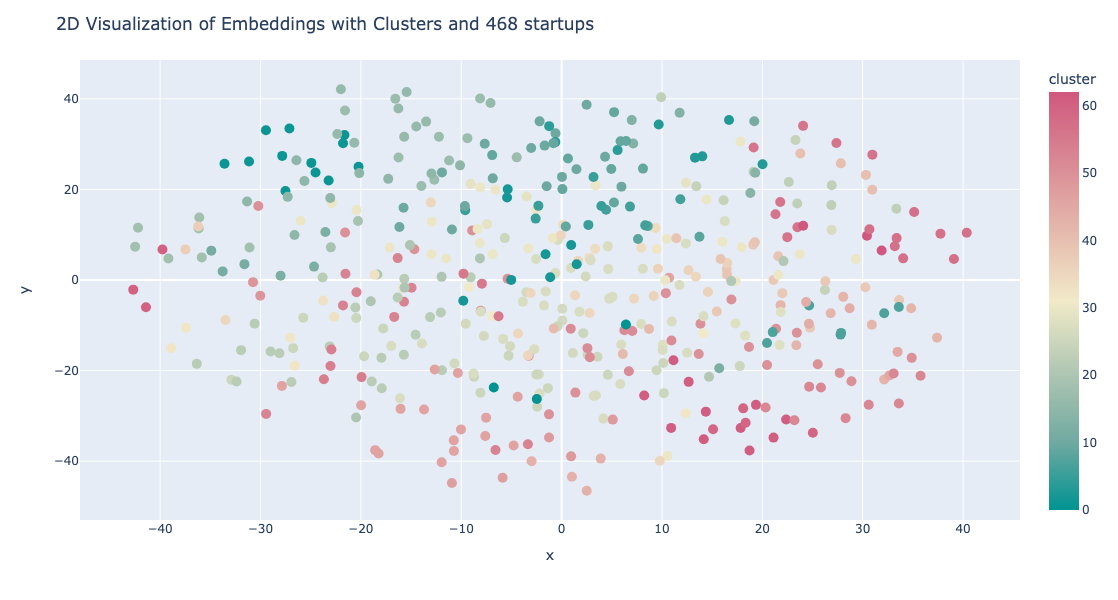

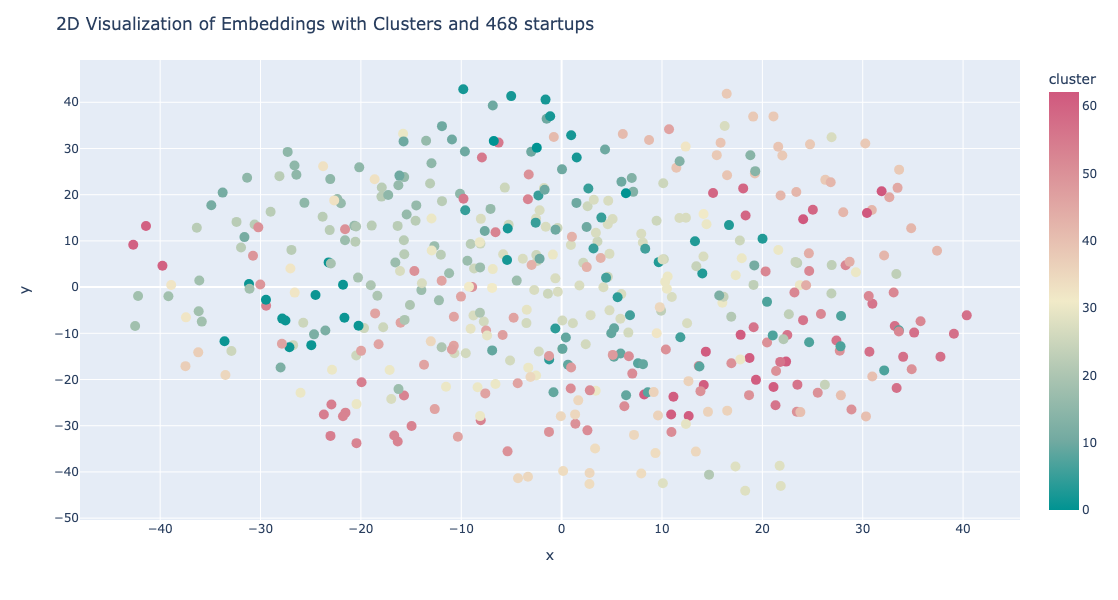

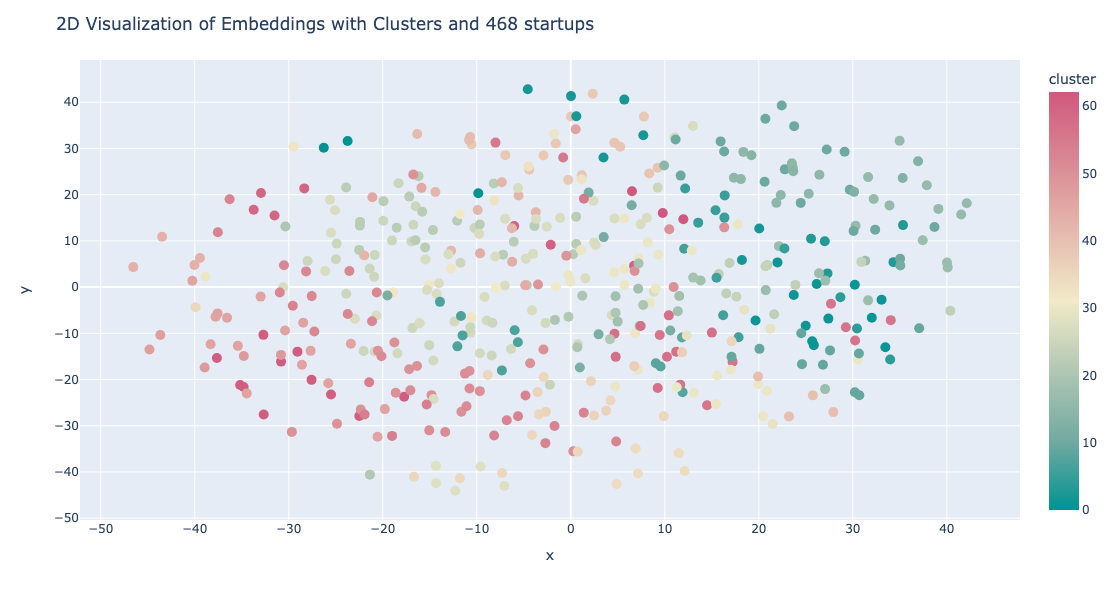

In [184]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px

# Assuming 'sample_df' contains a column 'openai_embedding_entire' with appropriate data
embeddings = np.vstack(sample_df['openai_embedding_entire'].values)

# Apply t-SNE to the embeddings with 3 components for 3D visualization
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results[:, [0,1]], columns=['x', 'y'])
plot_df['cluster'] =sample_df["new_cluster_index"]
plot_df['generated_cluster_label'] = sample_df["generated_cluster_label"] #+ " XX " + sample_df['Tasks/Jobs']
# Plot using Plotly with clusters
fig = px.scatter(plot_df, x='x', y='y',
                 color='cluster',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 hover_data=['generated_cluster_label'])
fig.update_traces(marker_size=10)
fig.update_layout(
    title=f"2D Visualization of Embeddings with Clusters and {len(sample_df)} startups", 
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)
fig.show()

# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results[:, [0,2]], columns=['x', 'y'])
plot_df['cluster'] =sample_df["new_cluster_index"]
plot_df['generated_cluster_label'] = sample_df["generated_cluster_label"] #+ " XX " + sample_df['Tasks/Jobs']
# Plot using Plotly with clusters
fig = px.scatter(plot_df, x='x', y='y',
                 color='cluster',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 hover_data=['generated_cluster_label'])
fig.update_traces(marker_size=10)
fig.update_layout(
    title=f"2D Visualization of Embeddings with Clusters and {len(sample_df)} startups", 
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)
fig.show()


# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results[:, [1,2]], columns=['x', 'y'])
plot_df['cluster'] =sample_df["new_cluster_index"]
plot_df['generated_cluster_label'] = sample_df["generated_cluster_label"] #+ " XX " + sample_df['Tasks/Jobs']
# Plot using Plotly with clusters
fig = px.scatter(plot_df, x='x', y='y',
                 color='cluster',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 hover_data=['generated_cluster_label'])
fig.update_traces(marker_size=10)
fig.update_layout(
    title=f"2D Visualization of Embeddings with Clusters and {len(sample_df)} startups", 
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)
fig.show()

In [108]:
fig.write_html("startups2.html")

sample_df['generated_cluster_label'].unique()

array(['Music and Audio Production Tools', 'AI Toolset for Developers',
       'Construction and Workflow Automation',
       'Web Development and AI tools', 'AI Research and Development',
       'Tech and Blockchain News', 'HR and Recruitment Automation',
       'Retail Supply Chain Management',
       'Advanced Cybersecurity Solutions',
       'Mobile and Software Development Technologies',
       'Educational Technologies and Learning Platforms',
       'Healthcare Data Management Systems', 'Creative Business Tools',
       'Restaurant and Hospitality Services',
       'Regulatory Compliance and Risk Management',
       'Gamification in Education', 'Marketing Data Analytics',
       'Personalized Wellness Programs', 'AI-Driven Business Strategies',
       'E-commerce and Retail Strategies', 'AI Systems Development',
       'Social Media and Marketing Strategies', 'Customer Data Analysis',
       'Automated Business Systems', 'Career Development Tools',
       'Veterinary and Pet Car

In [115]:
sample_df["task_list"] = sample_df["Tasks/Jobs"].apply(lambda x: x.split(", "))
task_df = sample_df.explode('task_list')
task_df

,Unnamed: 0,organization name,num employees,founded date,description,industries,headquarters location,description.1,cb rank,postal code,...,parsed_description,Tasks/Jobs,Industry,People Using Tool,openai_embedding_entire,cluster_label,generated_cluster_label,openai_embedding_industry,new_cluster_index,task_list
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"\nTasks/Jobs: Music Business Management, Marke...","Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Business Management
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"\nTasks/Jobs: Music Business Management, Marke...","Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Marketing
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"\nTasks/Jobs: Music Business Management, Marke...","Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Business Strategy
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"\nTasks/Jobs: Music Business Management, Marke...","Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Production
1,1,NaijaBuzz300,1-10,2024-03-03,NaijaBuzz300's AI content tools helps artists ...,Marketing,"Kaduna, Kaduna, Nigeria",Helping artists grow & scale up their music ca...,—,902101,...,"\nTasks/Jobs: Music production, Songwriting, M...","Music production, Songwriting, Marketing, Prom...",Music,"Musicians, Labels, Promoters","[-0.006098032463341951, -0.021988358348608017,...",33,Music and Audio Production Tools,"[0.018011273816227913, -0.006110658403486013, ...",61,Music production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,466,Localportal,1-10,2024-04-07,Localportal is the first pseudo operating syst...,"Artificial Intelligence (AI), Cloud Computing,...",—,Localportal revolutionizes access to remote co...,—,—,...,"\nTasks/Jobs: Remote access management, GPU re...","Remote access management, GPU resource allocat...",Remote computing,"Developers, Researchers, Data scientists","[-0.03364584222435951, 0.0008783882367424667, ...",83,High-Performance Computing Solutions,"[-0.02788754366338253, -0.01972130499780178, -...",0,Application deployment
467,467,Thunder,1-10,2024-02-02,Thunder is a Cloud computing to democratize ac...,"Artificial Intelligence (AI), Cloud Computing,...","Lewes, Delaware, United States",Thunder is a Cloud computing to democratize ac...,—,19958,...,"\nTasks/Jobs: GPU resour

In [116]:
pd.DataFrame(task_df.task_list.value_counts())

,count
task_list,
Data analysis,50
Content creation,33
Risk assessment,14
Lead generation,12
Inventory management,9
...,...
Reporting,1
Property management,1
Keyless entry,1


In [119]:
class chatGPT():
    def __init__(self):
        self.client = OpenAI(api_key=OPENAI_API_KEY)
        
    def ask(self, q):
        stream = self.client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": q}],
            stream=True,
            temperature=0
        )
        response = ""
        for chunk in stream:
            if chunk.choices[0].delta.content is not None:
                response += chunk.choices[0].delta.content

        self.response = response
        return response

    def get_embedding(self,text, model="text-embedding-3-large"):
       text = text.replace("\n", " ")
       return self.client.embeddings.create(input = [text], model=model).data[0].embedding

x = chatGPT()

In [120]:
task_df['open_ai_embedding_task'] = task_df["task_list"].apply(lambda text: x.get_embedding(text))

In [121]:
# task_df.to_csv("tasks.csv")

In [122]:
task_df

,Unnamed: 0,organization name,num employees,founded date,description,industries,headquarters location,description.1,cb rank,postal code,...,Tasks/Jobs,Industry,People Using Tool,openai_embedding_entire,cluster_label,generated_cluster_label,openai_embedding_industry,new_cluster_index,task_list,open_ai_embedding_task
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Business Management,"[0.0357237234711647, 0.005057905334979296, -0...."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Marketing,"[-0.018830178305506706, 0.012254700995981693, ..."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Business Strategy,"[0.0186082124710083, 0.00648229755461216, -0.0..."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",33,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Production,"[0.001785977277904749, -0.015392362140119076, ..."
1,1,NaijaBuzz300,1-10,2024-03-03,NaijaBuzz300's AI content tools helps artists ...,Marketing,"Kaduna, Kaduna, Nigeria",Helping artists grow & scale up their music ca...,—,902101,...,"Music production, Songwriting, Marketing, Prom...",Music,"Musicians, Labels, Promoters","[-0.006098032463341951, -0.021988358348608017,...",33,Music and Audio Production Tools,"[0.018011273816227913, -0.006110658403486013, ...",61,Music production,"[-0.014025893062353134, -0.01809188723564148, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,466,Localportal,1-10,2024-04-07,Localportal is the first pseudo operating syst...,"Artificial Intelligence (AI), Cloud Computing,...",—,Localportal revolutionizes access to remote co...,—,—,...,"Remote access management, GPU resource allocat...",Remote computing,"Developers, Researchers, Data scientists","[-0.03364584222435951, 0.0008783882367424667, ...",83,High-Performance Computing Solutions,"[-0.02788754366338253, -0.01972130499780178, -...",0,Application deployment,"[-0.03762552887201309, 0.02334844321012497, -0..."
467,467,Thunder,1-10,2024-02-02,Thunder is a Cloud computing to democratize ac...,"Artificial Intelligence (AI), Cloud Computing,...","Lewes, Delaware, United States",Thunder is a Cloud computing to democratize ac...,—,19958,...,"GPU resource allocat

In [173]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'sample_df' and its 'openai_embedding_entire' column exist and contain appropriate data
embeddings = np.array(task_df['open_ai_embedding_task'].tolist())

similarity_matrix = cosine_similarity(embeddings)
distance_matrix = 1 - similarity_matrix

# Define the number of neighbors
n_neighbors = 7

# Create a KNN model for connectivity based on cosine distance
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
knn.fit(embeddings)
connectivity_matrix = knn.kneighbors_graph(embeddings, mode='connectivity')

# Use Spectral Clustering with the connectivity matrix defined by KNN
clustering = SpectralClustering(n_clusters=700, affinity='precomputed', assign_labels='kmeans', random_state=42)
cluster_labels = clustering.fit_predict(connectivity_matrix)

# Assign cluster labels back to the original DataFrame
task_df['cluster_label'] = cluster_labels


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



In [181]:
task_df

,Unnamed: 0,organization name,num employees,founded date,description,industries,headquarters location,description.1,cb rank,postal code,...,Tasks/Jobs,Industry,People Using Tool,openai_embedding_entire,cluster_label,generated_cluster_label,openai_embedding_industry,new_cluster_index,task_list,open_ai_embedding_task
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",92,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Business Management,"[0.0357237234711647, 0.005057905334979296, -0...."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",285,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Marketing,"[-0.018830178305506706, 0.012254700995981693, ..."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",615,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Business Strategy,"[0.0186082124710083, 0.00648229755461216, -0.0..."
0,0,Semilla Co. (Flou / Seed Academy),1-10,2023-02-01,"Semilla Co. (""Seed"") is building the future of...","Consumer Software, Content Creators, EdTech, L...","Fort Lauderdale, Florida, United States",Building the future of the music and entertain...,"43,978",33316,...,"Music Business Management, Marketing, Business...",Music Industry,"Music Creators, Entrepreneurs","[-0.004338318016380072, -0.021966977044939995,...",697,Music and Audio Production Tools,"[0.026692301034927368, 0.013956104405224323, -...",61,Music Production,"[0.001785977277904749, -0.015392362140119076, ..."
1,1,NaijaBuzz300,1-10,2024-03-03,NaijaBuzz300's AI content tools helps artists ...,Marketing,"Kaduna, Kaduna, Nigeria",Helping artists grow & scale up their music ca...,—,902101,...,"Music production, Songwriting, Marketing, Prom...",Music,"Musicians, Labels, Promoters","[-0.006098032463341951, -0.021988358348608017,...",697,Music and Audio Production Tools,"[0.018011273816227913, -0.006110658403486013, ...",61,Music production,"[-0.014025893062353134, -0.01809188723564148, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,466,Localportal,1-10,2024-04-07,Localportal is the first pseudo operating syst...,"Artificial Intelligence (AI), Cloud Computing,...",—,Localportal revolutionizes access to remote co...,—,—,...,"Remote access management, GPU resource allocat...",Remote computing,"Developers, Researchers, Data scientists","[-0.03364584222435951, 0.0008783882367424667, ...",336,High-Performance Computing Solutions,"[-0.02788754366338253, -0.01972130499780178, -...",0,Application deployment,"[-0.03762552887201309, 0.02334844321012497, -0..."
467,467,Thunder,1-10,2024-02-02,Thunder is a Cloud computing to democratize ac...,"Artificial Intelligence (AI), Cloud Computing,...","Lewes, Delaware, United States",Thunder is a Cloud computing to democratize ac...,—,19958,...,"GPU resource al

In [183]:
embedding1 = np.array([task_df['open_ai_embedding_task'].iloc[-4]])  # Using .iloc[] for safe indexing
embedding2 = np.array([task_df['open_ai_embedding_task'].iloc[-3]])

# Compute cosine similarity between the first two embeddings in the DataFrame
similarity_score = cosine_similarity(embedding1, embedding2)
similarity_score

array([[0.5838231]])

In [174]:
for i in range(10):
    num_companies = len(task_df[task_df["cluster_label"] == i])
    print(f"Cluster {i}, Number of companies: {num_companies}")

Cluster 0, Number of companies: 3
Cluster 1, Number of companies: 17
Cluster 2, Number of companies: 1
Cluster 3, Number of companies: 2
Cluster 4, Number of companies: 2
Cluster 5, Number of companies: 3
Cluster 6, Number of companies: 2
Cluster 7, Number of companies: 1
Cluster 8, Number of companies: 7
Cluster 9, Number of companies: 5


In [195]:
for i, x in sample_df[["parsed_description", "organization name"]].iterrows():
    print(x["organization name"],x["parsed_description"])


Semilla Co. (Flou / Seed Academy) 
Tasks/Jobs: Music Business Management, Marketing, Business Strategy, Music Production
Industry: Music Industry
People Using Tool: Music Creators, Entrepreneurs 
 

NaijaBuzz300 
Tasks/Jobs: Music production, Songwriting, Marketing, Promotion
Industry: Music
People Using Tool: Musicians, Labels, Promoters 
 

SONOTELLER 
Tasks/Jobs: Music analysis, Playlist creation, Music discovery, Audience profiling
Industry: Music technology
People Using Tool: Music enthusiasts, Music professionals 
 

AISong 
Tasks/Jobs: Song composition, Music production, Lyrics generation, Music exploration
Industry: Music creation
People Using Tool: Artists, Creators, Musicians
 

SoundAI 
Tasks/Jobs: Music generation, Sound design, Audio mixing, Mastering 
Industry: Music production 
People Using Tool: Musicians, Producers 
 

Vibey 
Tasks/Jobs: Music creation, Music collaboration, Gig booking, Music discovery
Industry: Music
People Using Tool: Musicians, Music enthusiasts
 



In [175]:
for i in range(0,10):
    print(f"Processing {i}:\n************************\n")
    vals = task_df[task_df["cluster_label"]==i]
    for index, row in vals.iterrows():
        print(f"Organization Name: {row['organization name']}")
        print(f"Task: {row['task_list']}")
        print(f"Generated Description: {row['People Using Tool']}\n")
    print(f"************************\n\n")

Processing 0:
************************

Organization Name: Go Boldly
Task: Financial literacy
Generated Description: Young adults

Organization Name: Onlinezms.com
Task: Financial education
Generated Description:  Individuals, Investors 

Organization Name: Topy AI
Task: Financial mentoring
Generated Description: Entrepreneurs, Startups

************************


Processing 1:
************************

Organization Name: SoundAI
Task: Music generation
Generated Description: Musicians, Producers 

Organization Name: Simoto AI
Task: Content creation
Generated Description: Bloggers, Content creators 

Organization Name: Outhire
Task: Content creation
Generated Description: Recruiters, HR teams

Organization Name: Causatum Pictures
Task: Distribution
Generated Description: Filmmakers, Viewers 

Organization Name: Reactable AI
Task: Content creation
Generated Description: Marketers, Influencers, Educators, Politicians, SMBs, Startups

Organization Name: GetSite
Task: Content creation
Gener

In [138]:
y = pd.DataFrame(sample_df.generated_cluster_label.value_counts()).reset_index()
for i,row in y.iterrows():
    print(row["generated_cluster_label"],row["count"])

AI Systems Development 37
Automated Business Systems 28
AI Research and Development 22
Mobile and Software Development Technologies 21
Creative Business Tools 20
Financial Management Systems 17
Educational Technologies and Learning Platforms 17
Social Media and Digital Insights 12
Advanced Cybersecurity Solutions 12
Sales and Marketing Outreach 11
AI Toolset for Developers 11
Music and Audio Production Tools 11
HR and Recruitment Automation 11
Regulatory Compliance and Risk Management 10
Venture Capital and Financing 10
Healthcare Data Management Systems 9
Animation and Visual Effects Tools 9
Real Estate Investment Analysis 9
Restaurant and Hospitality Services 8
Personalized Wellness Programs 8
Data Management and Quality Control 8
Travel Booking and Planning Systems 8
Image Enhancement Solutions 7
Creative Content and Media Tools 7
E-commerce and Retail Strategies 7
Legal and Technological Automation 7
Project and Team Management 7
Web Development and AI tools 6
Data Insights and Ana

In [140]:
list(sample_df.Industry)

['Music Industry',
 'Music',
 'Music technology',
 'Music creation',
 'Music production ',
 'Music',
 'Content creation',
 'Content creation',
 'Podcast discovery',
 'Content creation',
 'Music production',
 'Language AI',
 'Business automation',
 'AI language model',
 'AI Solutions',
 'AI platform',
 'Conversational AI',
 ' AI Development',
 'IT Services',
 'No-code AI platform',
 'AI Services',
 'AI development platform',
 'Construction',
 'Construction',
 'Legal tech',
 'Website optimization',
 'Moving and relocation',
 'Website analytics',
 'Software Testing',
 'Website migration',
 'Domain name registration and management',
 'AI Research',
 'Database management',
 'Consumer goods',
 'Software development',
 'AI information and guidance',
 'Artificial Intelligence',
 'Search Engine',
 'Knowledge Management',
 'Information management',
 'Artificial Intelligence Research & Development',
 'AI Training Data',
 'AI tools discovery',
 'AI/ML/DL development',
 'AI Marketplace',
 'Informat

In [144]:
list(sample_df["People Using Tool"])

['Music Creators, Entrepreneurs ',
 'Musicians, Labels, Promoters ',
 'Music enthusiasts, Music professionals ',
 'Artists, Creators, Musicians',
 'Musicians, Producers ',
 'Musicians, Music enthusiasts',
 'Authors, Writers, Podcasters',
 'Bloggers, Marketers, Content creators',
 'Podcast listeners, Podcast enthusiasts',
 'Bloggers, Content creators ',
 'Musicians, Producers',
 'Dutch speakers, Anyone',
 'Businesses, Professionals ',
 'Writers, Researchers, Educators, Students',
 'Businesses, Organizations',
 'Developers, Business professionals ',
 'Everyone, Students, Professionals',
 'Developers, Businesses ',
 'Businesses, Marketers',
 'Businesses, Individuals, Marketers',
 'Developers, Businesses',
 'Developers, Businesses ',
 'Architects, Engineers',
 'Architects, Contractors',
 'Lawyers, Construction professionals',
 'Developers, Marketers',
 'Movers, Homeowners ',
 'Website owners, Marketers',
 'Developers, Testers ',
 'Web developers, Business owners',
 'Web developers, Domain 

In [147]:
sample_df.task_list

0      [Music Business Management, Marketing, Busines...
1      [Music production, Songwriting, Marketing, Pro...
2      [Music analysis, Playlist creation, Music disc...
3      [Song composition, Music production, Lyrics ge...
4      [Music generation, Sound design, Audio mixing,...
                             ...                        
463    [Habit tracking, Goal setting, Productivity op...
464    [Content Summarization, Information Organizati...
465    [Model optimization, Algorithm development, AI...
466    [Remote access management, GPU resource alloca...
467    [GPU resource allocation, Access to unused GPU...
Name: task_list, Length: 468, dtype: object

In [185]:
x = sample_df[sample_df.generated_cluster_label=="Creative Business Tools"]
for i in range(len(x)):
    
    print(x.generated_description.iloc[i])
    print(x.parsed_description.iloc[i])

DreamGenerator.ai is an innovative platform that utilizes generative AI to transform user ideas into stunning and diverse images. It offers a unique creative experience, encouraging users to experiment with prompts and share their AI-generated art, while also providing an opportunity to receive recognition through likes and shares.

Tasks/Jobs: Image generation, Artistic exploration, Prompt engineering, Social media sharing
Industry: Creative arts
People Using Tool: Artists, Designers, Everyone
 

WriteO is a comprehensive platform designed to streamline the novel writing process with sophisticated organizational tools, AI-assisted character development, and a supportive community. It enables writers to concentrate on their creativity, effortlessly handling the intricacies of storytelling.

Tasks/Jobs: Character development, Story outlining, Scene writing, Manuscript editing
Industry: Novel writing
People Using Tool: Authors, Writers
 

AIrtizen is a solopreneur-driven venture that spe

In [157]:
sample_df[sample_df.generated_cluster_label=="Personal Growth and Development"]

,Unnamed: 0,organization name,num employees,founded date,description,industries,headquarters location,description.1,cb rank,postal code,...,parsed_description,Tasks/Jobs,Industry,People Using Tool,openai_embedding_entire,cluster_label,generated_cluster_label,openai_embedding_industry,new_cluster_index,task_list
462,462,ProperPlan,1-10,2023-09-04,ProperPlan bridges the gap between goals and a...,"Artificial Intelligence (AI), Business Develop...","Birmingham, Birmingham, United Kingdom",ProperPlan bridges the gap between goals and a...,"66,694",B12LP,...,"\nTasks/Jobs: Goal setting, Action planning, P...","Goal setting, Action planning, Progress tracki...",Goal achievement,"Individuals, Businesses","[-0.0014259921154007316, 0.007959303446114063,...",39,Personal Growth and Development,"[-0.00491522578522563, 0.0010107189882546663, ...",44,"[Goal setting, Action planning, Progress track..."
463,463,Regimen,1-10,2023-10-06,Regimen helps ambitious professionals apply th...,—,—,"Ed-tech AI platform, Consumer App, Marketplace",—,—,...,"\nTasks/Jobs: Habit tracking, Goal setting, Pr...","Habit tracking, Goal setting, Productivity opt...",Personal Development,"Professionals, Ambitious individuals","[-0.016550462692975998, 0.014065012335777283, ...",39,Personal Growth and Development,"[-0.008851252496242523, 0.0409066341817379, -0...",44,"[Habit tracking, Goal setting, Productivity op..."
464,464,Dropofwisdom,1-10,2023-05-15,—,—,—,Providing personal growth and self-help conten...,"3,061,012",—,...,"\nTasks/Jobs: Content Summarization, Informati...","Content Summarization, Information Organizatio...",Personal Growth,"Everyone, Individuals","[-0.006916402373462915, -0.004029091913253069,...",39,Personal Growth and Development,"[-0.011301263235509396, 0.03004414588212967, -...",44,"[Content Summarization, Information Organizati..."


In [162]:
x.generated_description

462    ProperPlan is an AI-driven platform that helps...
463    Regimen is an AI-powered platform designed to ...
464    Dropofwisdom, found at fillerkiller.net, is an...
Name: generated_description, dtype: object

In [172]:
for x in task_df.groupby("generated_cluster_label"):
    print(x[0])
    print("*********************")
    y = x[1].task_list.value_counts().reset_index()
    for i,row in y.iterrows():
        print(row["task_list"],row["count"])
    print("*********************\n\n")

AI Research and Development
*********************
Information retrieval 4
AI model training 2
AI research 2
AI deployment 2
AI development 2
Research 2
Knowledge sharing 2
 Answer generation 2
AI tool selection 2
AI tool discovery 2
AI model integration 2
Business process automation 1
Data security 1
AI tool access 1
AI model inference 1
Serverless computing 1
AI application procurement 1
AI integration 1
 Information extraction 1
 Document analysis 1
AI management 1
Document summarization 1
Data search 1
Data analysis 1
Knowledge discovery 1
Research paper discovery 1
Documentation 1
Research paper summarization 1
Knowledge management 1
Literature review creation 1
Knowledge extraction 1
AI tool integration 1
Model execution 1
Cost optimization 1
AI adoption 1
AI Tool Discovery 1
AI Tool Evaluation 1
AI Tool Comparison 1
AI Tool Collaboration 1
AI news updates 1
AI project management 1
AI interface design 1
Biometric Data Collection 1
AI tool comparison 1
Data Labeling 1
User interact

In [197]:
sample_df[["organization name","generated_description","website","parsed_description"]].to_csv("descriptions.csv")